# Part 2, Topic 1, Lab B: Power Analysis for Password Bypass (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *This tutorial will introduce you to breaking devices by determining when a device is performing certain operations. Our target device will be performing a simple password check, and we will demonstrate how to perform a basic power analysis.*

**LEARNING OUTCOMES:**

* How power can be used to determine timing information.
* Plotting multiple iterations while varying input data to find interesting locations.
* Using difference of waveforms to find interesting locations.
* Performing power captures with ChipWhisperer hardware (hardware only)


## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ Jupyter Notebook Intro (you should be OK with plotting & running blocks).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).

## Power Trace Gathering

At this point you've got to insert code to perform the power trace capture. There are two options here:
* Capture from physical device.
* Read from a file.

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the next cell, otherwise things will fail later on!


In [26]:
%run "traces/password_sim.ipynb"

trace_test = cap_pass_trace("h\n")

#Basic sanity check
assert(len(trace_test) == 3000)
print("✔️ OK to continue!")

✔️ OK to continue!


## Exploration

So what can we do with this? While first off - I'm going to cheat, and tell you that we have a preset password that starts with `h`, and it's 5 characters long. But that's the only hint so far - what can you do? While first off, let's try plotting a comparison of `h` to something else.

If you need a reminder of how to do a plot - see the matplotlib section of the **Jupyter Introduction** notebook.

The following cell shows you how to capture one power trace with `h` sent as a password. From there:

1. Try adding the plotting code and see what it looks like.
2. Send different passwords to the device. We're only going to look at the difference between a password starting with `h` and something else right now.
3. Plot the different waveforms.

[-0.02148438 -0.203125   -0.1484375  ... -0.17578125 -0.09667969
 -0.03515625]


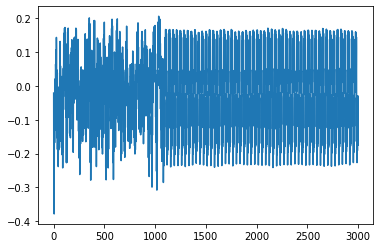

In [27]:
#Example - capture 'h' - end with newline '\n' as serial protocol expects that
trace_h = cap_pass_trace("h\n")

print(trace_h)
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(trace_h)
plt.show()

For reference, the output should look something like this:
<img src="img/spa_password_h_vs_0_overview.png" alt="SPA of Power Analysis" width="450"/>

If you are using the `%matplotlib notebook` magic, you can zoom in at the start. What you want to notice is there is two code paths taken, depending on a correct or incorrect path. Here for example is a correct & incorrect character processed:
<img src="img/spa_password_h_vs_0_zoomed.png" alt="SPA of Power Analysis" width="450"/>

OK interesting -- what's next? Let's plot every possible password character we could send.

Our password implementation only recognizes characters in the list `abcdefghijklmnopqrstuvwxyz0123456789`, so we're going to limit it to those valid characters for now.

Write some code in the following block that implements the following algorithm:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace)
        
The above isn't quite valid code - so massage it into place! You also may notice the traces are way too long - you might want to make a more narrow plot that only does the first say 500 samples of the power trace.

---
📝**Plotting Note**

If using `matplotlib` for plotting, you might need to add a `plt.figure()` at the start to make a new figure. Otherwise you might find your plot ends up in the figure above! If you don't see the plots, sometimes a `plt.show()` is needed at the end.

---

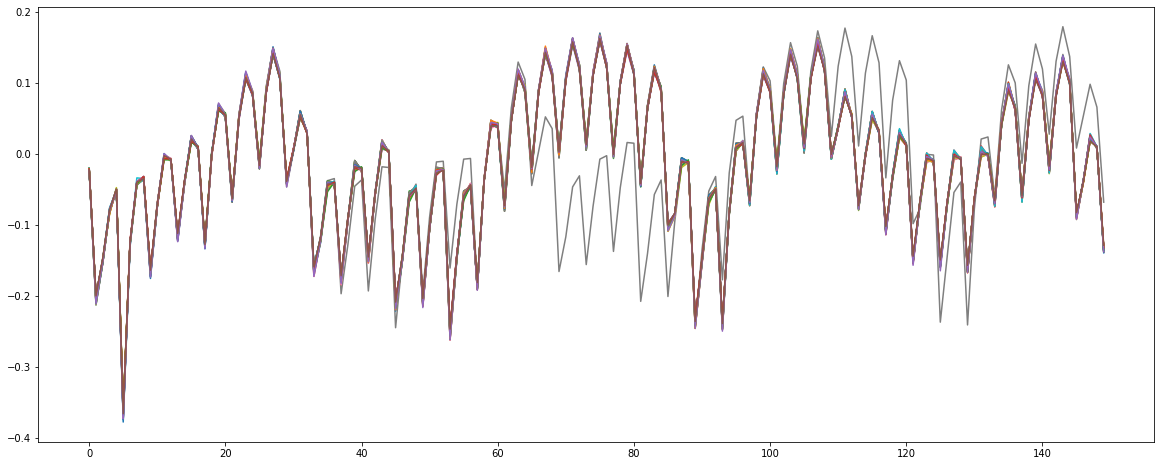

In [32]:
import string
char_list = list(string.ascii_lowercase)
char_list.extend(list(string.digits))
plt.rcParams['figure.figsize'] = [20, 8]
for char in char_list:
    trace = cap_pass_trace(char + "\n")
    plt.plot(trace[0:150])

plt.show()

The end result should be if you zoom in, you'll see there is a location where a single "outlier" trace doesn't follow the path of all the other traces. That is great news, since it means we learn something about the system from power analysis.

<img src="img/spa_password_list_char1.png" alt="SPA of Power Analysis against all inputs" width="450"/>

Using your loop - you can also try modifying the analysis to capture a correct "first" character, and then every other wrong second character. Do you see a difference you might be able to detect?

The pseudo-code would look something like this:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace("h" + CHARACTER + "\n")
        plot(trace)

Give that a shot in your earlier code-block, and then let's try and automate this attack to understand the data a little better.

## Automating an Attack against One Character

To start with - we're going to automate an attack against a **single** character of the password. Since we don't know the password (let's assume), we'll use a strategy of comparing all possible inputs together.

An easy way to do this might be to use something that we know can't be part of the valid password. As long as it's processed the same way, this will work just fine. So for now, let's use a password as `0x00` (i.e., a null byte). We can compare the null byte to processing something else:

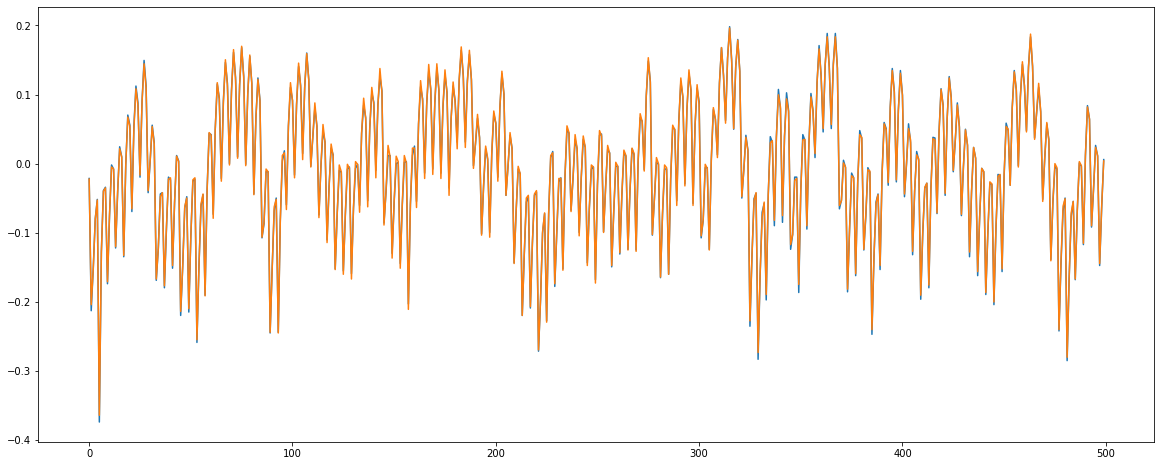

In [23]:

plt.figure()
ref_trace = cap_pass_trace("\x00\n")[0:500]
plt.plot(ref_trace)
other_trace = cap_pass_trace("c\n")[0:500]
plt.plot(other_trace)

This will plot a trace with an input of "\x00" - a null password! This is an invalid character, and seems to be processed as any other invalid password.

Let's make this a little more obvious, and plot the difference between a known reference & every other capture. You need to write some code that does something like this:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace - ref_trace)

Again, you may need to modify this a little bit such as adding code to make a new `figure()`. Also notice in the above example how I reduced the number of samples.


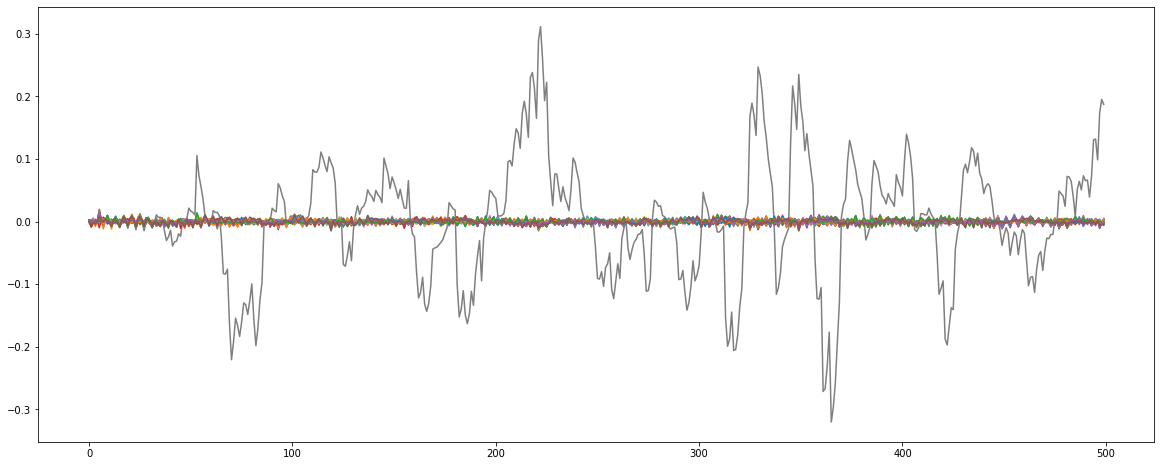

In [37]:
ref_trace = cap_pass_trace("\x00\n")
for char in char_list:
    trace = cap_pass_trace(char +"\n")
    plt.plot((trace - ref_trace)[0:500])

plt.show()

OK great - hopefully you now see one major "difference". It should look something like this:
    
<img src="img/spa_password_diffexample.png" alt="SPA with Difference" width="450"/>
    

What do do now? Let's make this thing automatically detect such a large difference. Some handy stuff to try out is the `np.sum()` and `np.abs()` function.

The first one will get absolute values:

```python
import numpy as np
np.abs([-1, -3, 1, -5, 6])

    Out[]: array([1, 3, 1, 5, 6])
```

The second one will add up all the numbers.

```python
import numpy as np    
np.sum([-1, -3, 1, -5, 6])

    Out[]: -2
```

Using just `np.sum()` means positive and negative differences will cancel each other out - so it's better to do something like `np.sum(np.abs(DIFF))` to get a good number indicating how "close" the match was.


In [38]:
import numpy as np
np.abs([-1, -3, 1, -5, 6])

array([1, 3, 1, 5, 6])

In [39]:
import numpy as np
np.sum([-1, -3, 1, -5, 6])

-2

In [40]:
np.sum(np.abs([-1, -3, 1, -5, 6]))

16

Taking your above loop, modify it to print an indicator of how closely this matches your trace. Something like the following should work:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        diff = SUM(ABS(trace - ref_trace))

        print("{:1} diff = {:2}".format(CHARACTER, diff))

In [47]:
ref_trace = cap_pass_trace("\x00\n")

for char in char_list:
    trace = cap_pass_trace(char + "\n")
    diff = np.sum(np.abs(trace-ref_trace))
    if diff > 25.0:
        print("Correct char found: " + char + ", with diff = "+ str(diff))
        break

Correct char found: h, with diff = 96.7841796875


Now the easy part - modify your above code to automatically print the correct password character. This should be done with a comparison of the `diff` variable - based on the printed characters, you should see one that is 'higher' than the others. Set a threshold somewhere reasonable (say I might use `25.0` based on one run).

## Running a Full Attack

Finally - let's finish this off. Rather than attacking a single character, we need to attack each character in sequence.

If you go back to the plotting of differences, you can try using the correct first character & wrong second character. The basic idea is exactly the same as before, but now we loop through 5 times, and just build up the password based on brute-forcing each character.

Take a look at the following for the basic pseudo-code:

    guessed_pw = "" #Store guessed password so far
    
    do a loop 5 times (max password size):
        
        ref_trace = capture power trace(guessed_pw + "\x00\n")
        
        for CHARACTER in LIST_OF_VALID_CHARACTERS:
            trace = capture power trace (guessed_pw + CHARACTER + newline)
            diff = SUM(ABS(trace - ref_trace))
            
            if diff > THRESHOLD:
                
                guessed_pwd += c
                print(guessed_pw)
                
                break


In [50]:
guess = ""
for i in range(5):
    ref_trace = cap_pass_trace(guess +"\x00\n")
    for char in char_list:
        trace = cap_pass_trace(guess + char +"\n")
        diff = np.sum(np.abs(trace-ref_trace))
        if diff > 25.0:
            print("Correct char found: " + char + ", with diff = "+ str(diff))
            guess += char
            break

Correct char found: h, with diff = 99.990234375
Correct char found: 0, with diff = 100.72265625
Correct char found: p, with diff = 100.23046875
Correct char found: x, with diff = 100.0703125
Correct char found: 3, with diff = 298.8017578125


You should get an output that looks like this:

    h
    h0
    h0p
    h0px
    h0px3

If so - 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳 Congrats - you did it!!!!

If not - check some troubleshooting hints below. If you get really stuck, check the `SOLN` version (there is one for both with hardware and simulated).

---
## Troubleshooting

Some common problems you might run into - first, if you get an output which keeps guessing the first character:

### Always get 'h'

    h
    hh
    hhh
    hhhh
    hhhhh

Check that when you run the `cap_pass_trace` inside the loop (checking the guessed password), are you updating the prefix of the password? For example, the old version of the code (guessing a single character) looked like this:

    trace = cap_pass_trace(c + "\n")

But that is always sending our first character only! So we need to send the "known good password so far". In the example code something like this:
   
    trace = cap_pass_trace(guessed_pw + c + "\n")

Where `guessed_pw` progressively grows with the known good start of the password.

### Always get 'a'

This looks like it's always matching the first character:

    h
    ha
    haa
    haaa
    haaaa

Check that you update the `ref_trace` - if you re-use the original reference trace, you won't be looking at a reference where the first N characters are good, and the remaining characters are bad. An easy way to do this is again using the `guessed_pw` variable and appending a null + newline:

    trace = cap_pass_trace(guessed_pw + "\x00\n")

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>